In [1]:
import os
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from ezc3d import c3d
from scipy.signal import resample
from scipy.io import loadmat, savemat
from joblib import load, dump
from tqdm import tqdm
from scipy.signal import butter, lfilter

In [2]:
PATH_DATASETS = '../../Dataset/'
PATH_DATASET_2 = 'gait-dbase-2/'

N_SAMPLES = 1024
FORCE_THRESHOLD = 20
TOE_HEIGTH_THRESHOLD = 40

In [3]:
class GrfFilter(object): 
    @staticmethod
    def butter_lowpass(cutoff, fs, order):
        nyq = 0.5 * fs
        normal_cutoff = cutoff / nyq
        b, a = butter(order, normal_cutoff, btype='low', analog=False)
        return b, a

    def apply(data, cutoff=10, fs=2000, order=2):
        b, a = GrfFilter.butter_lowpass(cutoff, fs, order=order)
        y = lfilter(b, a, data)
        y = y - np.median(y)
        return y

In [4]:
def standardize(x):
    return (x - np.mean(x, axis=0)) / np.std(x, axis=0)

def require_positive(x):
    if x < 0:
        return 0
    else:
        return x

def clip_overflow(x, max=N_SAMPLES):
    if x >= max:
        return N_SAMPLES - 1
    else:
        return x

In [5]:
path = os.path.join(PATH_DATASETS, PATH_DATASET_2)
subjects = os.listdir(path)

features = pd.DataFrame()
target = pd.DataFrame()

records = []
n_samples = 0
n_bad_samples = 0

for subject in tqdm(subjects):
    velocities_path = os.path.join(path, subject, 'Raw_Data')
    velocities = os.listdir(velocities_path)

    for velocity in velocities:

        files_path = os.path.join(velocities_path, velocity)
        files = os.listdir(files_path)

        for filename in files:
            try:
                content = c3d(os.path.join(files_path, filename), extract_forceplat_data=True)
            
                trajectory_x_r = content['data']['points'][0, 6:11, :]
                trajectory_y_r = content['data']['points'][1, 6:11, :]
                trajectory_z_r = content['data']['points'][2, 6:11, :]

                trajectory_x_l = content['data']['points'][0, 18:23, :]
                trajectory_y_l = content['data']['points'][1, 18:23, :]
                trajectory_z_l = content['data']['points'][2, 18:23, :]

                trajectory_x_r = resample(trajectory_x_r, N_SAMPLES, axis=1).T
                trajectory_y_r = resample(trajectory_y_r, N_SAMPLES, axis=1).T
                trajectory_z_r = resample(trajectory_z_r, N_SAMPLES, axis=1).T

                trajectory_x_l = resample(trajectory_x_l, N_SAMPLES, axis=1).T
                trajectory_y_l = resample(trajectory_y_l, N_SAMPLES, axis=1).T
                trajectory_z_l = resample(trajectory_z_l, N_SAMPLES, axis=1).T

                # ...................... Force X ...........................

                # force_x_1 = content['data']['platform'][0]['force'][0, :]
                force_x_2 = content['data']['platform'][1]['force'][0, :]
                force_x_3 = content['data']['platform'][2]['force'][0, :]
                force_x_4 = content['data']['platform'][3]['force'][0, :]
                force_x_5 = content['data']['platform'][4]['force'][0, :]
                # force_x_6 = content['data']['platform'][5]['force'][0, :]

                # .................... Fix sign of left foot .....................
                force_x_3 = -force_x_3
                force_x_5 = -force_x_5

                # force_x_1 = GrfFilter.apply(force_x_1)
                force_x_2 = GrfFilter.apply(force_x_2)
                force_x_3 = GrfFilter.apply(force_x_3)
                force_x_4 = GrfFilter.apply(force_x_4)
                force_x_5 = GrfFilter.apply(force_x_5)
                # force_x_6 = GrfFilter.apply(force_x_6)

                # force_x_1 = resample(force_x_1, N_SAMPLES, axis=0).T
                force_x_2 = resample(force_x_2, N_SAMPLES, axis=0).T
                force_x_3 = resample(force_x_3, N_SAMPLES, axis=0).T
                force_x_4 = resample(force_x_4, N_SAMPLES, axis=0).T
                force_x_5 = resample(force_x_5, N_SAMPLES, axis=0).T
                # force_x_6 = resample(force_x_6, N_SAMPLES, axis=0).T

                # ..................... Force Y ...........................

                # force_y_1 = content['data']['platform'][0]['force'][1, :]
                force_y_2 = content['data']['platform'][1]['force'][1, :]
                force_y_3 = content['data']['platform'][2]['force'][1, :]
                force_y_4 = content['data']['platform'][3]['force'][1, :]
                force_y_5 = content['data']['platform'][4]['force'][1, :]
                # force_y_6 = content['data']['platform'][5]['force'][1, :]

                # force_y_1 = GrfFilter.apply(force_y_1)
                force_y_2 = GrfFilter.apply(force_y_2)
                force_y_3 = GrfFilter.apply(force_y_3)
                force_y_4 = GrfFilter.apply(force_y_4)
                force_y_5 = GrfFilter.apply(force_y_5)
                # force_y_6 = GrfFilter.apply(force_y_6)

                # force_y_1 = resample(force_y_1, N_SAMPLES, axis=0).T
                force_y_2 = resample(force_y_2, N_SAMPLES, axis=0).T
                force_y_3 = resample(force_y_3, N_SAMPLES, axis=0).T
                force_y_4 = resample(force_y_4, N_SAMPLES, axis=0).T
                force_y_5 = resample(force_y_5, N_SAMPLES, axis=0).T
                # force_y_6 = resample(force_y_6, N_SAMPLES, axis=0).T

                # ....................... Force Z ............................

                # force_z_1 = content['data']['platform'][0]['force'][2, :]
                force_z_2 = content['data']['platform'][1]['force'][2, :]
                force_z_3 = content['data']['platform'][2]['force'][2, :]
                force_z_4 = content['data']['platform'][3]['force'][2, :]
                force_z_5 = content['data']['platform'][4]['force'][2, :]
                # force_z_6 = content['data']['platform'][5]['force'][2, :]

                # force_z_1 = GrfFilter.apply(force_z_1)
                force_z_2 = GrfFilter.apply(force_z_2)
                force_z_3 = GrfFilter.apply(force_z_3)
                force_z_4 = GrfFilter.apply(force_z_4)
                force_z_5 = GrfFilter.apply(force_z_5)
                # force_z_6 = GrfFilter.apply(force_z_6)

                # force_z_1 = resample(force_z_1, N_SAMPLES, axis=0).T
                force_z_2 = resample(force_z_2, N_SAMPLES, axis=0).T
                force_z_3 = resample(force_z_3, N_SAMPLES, axis=0).T
                force_z_4 = resample(force_z_4, N_SAMPLES, axis=0).T
                force_z_5 = resample(force_z_5, N_SAMPLES, axis=0).T
                # force_z_6 = resample(force_z_6, N_SAMPLES, axis=0).T

                # ... Remove all zero GRF samples
                if np.mean(force_z_2) <= FORCE_THRESHOLD or np.mean(force_z_3) <= FORCE_THRESHOLD \
                    or np.mean(force_z_4) <= FORCE_THRESHOLD or np.mean(force_z_5) <= FORCE_THRESHOLD:
                    n_bad_samples = n_bad_samples + 1
                    continue

                grf_combined_x_r = force_x_2 + force_x_4
                grf_combined_x_l = force_x_3 + force_x_5
                grf_combined_y_r = force_y_2 + force_y_4
                grf_combined_y_l = force_y_3 + force_y_5
                grf_combined_z_r = force_z_2 + force_z_4
                grf_combined_z_l = force_z_3 + force_z_5

                grf_mask_r = (grf_combined_z_r >= FORCE_THRESHOLD)
                grf_mask_l = (grf_combined_z_l >= FORCE_THRESHOLD)

                grf_start_r = np.min(np.argwhere(grf_mask_r == True))
                grf_end_r = np.max(np.argwhere(grf_mask_r == True))
                grf_start_l = np.min(np.argwhere(grf_mask_l == True))
                grf_end_l = np.max(np.argwhere(grf_mask_l == True))

                swing_period_r = np.sum(grf_combined_z_r[grf_start_r:grf_end_r] <= FORCE_THRESHOLD)
                swing_period_l = np.sum(grf_combined_z_l[grf_start_l:grf_end_l] <= FORCE_THRESHOLD)

                roi_start_r = require_positive(grf_start_r - swing_period_r)
                roi_end_r = clip_overflow(grf_end_r + swing_period_r)

                roi_start_l = require_positive(grf_start_l - swing_period_l)
                roi_end_l = clip_overflow(grf_end_l + swing_period_l)

                trajectory_x_r = trajectory_x_r[roi_start_l:roi_end_l]
                trajectory_x_l = trajectory_x_l[roi_start_r:roi_end_r]
                trajectory_y_r = trajectory_y_r[roi_start_l:roi_end_l]
                trajectory_y_l = trajectory_y_l[roi_start_r:roi_end_r]
                trajectory_z_r = trajectory_z_r[roi_start_l:roi_end_l]
                trajectory_z_l = trajectory_z_l[roi_start_r:roi_end_r]

                force_x_r = grf_combined_x_r[roi_start_r:roi_end_r]
                force_x_l = grf_combined_x_l[roi_start_l:roi_end_l]
                force_y_r = grf_combined_y_r[roi_start_r:roi_end_r]
                force_y_l = grf_combined_y_l[roi_start_l:roi_end_l]
                force_z_r = grf_combined_z_r[roi_start_r:roi_end_r]
                force_z_l = grf_combined_z_l[roi_start_l:roi_end_l]

                trajectory_x_r = resample(trajectory_x_r, N_SAMPLES, axis=0)
                trajectory_x_l = resample(trajectory_x_l, N_SAMPLES, axis=0)
                trajectory_y_r = resample(trajectory_y_r, N_SAMPLES, axis=0)
                trajectory_y_l = resample(trajectory_y_l, N_SAMPLES, axis=0)
                trajectory_z_r = resample(trajectory_z_r, N_SAMPLES, axis=0)
                trajectory_z_l = resample(trajectory_z_l, N_SAMPLES, axis=0)

                force_x_r = resample(force_x_r, N_SAMPLES, axis=0)
                force_x_l = resample(force_x_l, N_SAMPLES, axis=0)
                force_y_r = resample(force_y_r, N_SAMPLES, axis=0)
                force_y_l = resample(force_y_l, N_SAMPLES, axis=0)
                force_z_r = resample(force_z_r, N_SAMPLES, axis=0)
                force_z_l = resample(force_z_l, N_SAMPLES, axis=0)

                # ... Standardize
                trajectory_x_r = standardize(trajectory_x_r)
                trajectory_x_l = standardize(trajectory_x_l)
                trajectory_y_r = standardize(trajectory_y_r)
                trajectory_y_l = standardize(trajectory_y_l)
                trajectory_z_r = standardize(trajectory_z_r)
                trajectory_z_l = standardize(trajectory_z_l)

                force_x_r = standardize(force_x_r)
                force_x_l = standardize(force_x_l)
                force_y_r = standardize(force_y_r)
                force_y_l = standardize(force_y_l)
                force_z_r = standardize(force_z_r)
                force_z_l = standardize(force_z_l)


                _features_l = pd.DataFrame(
                    np.concatenate([trajectory_x_l, trajectory_y_l, trajectory_z_l], axis=1),
                    columns=[
                        '7_x', '8_x', '9_x', '10_x', '11_x',
                        '7_y', '8_y', '9_y', '10_y', '11_y',
                        '7_z', '8_z', '9_z', '10_z', '11_z'
                    ]
                )

                _features_r = pd.DataFrame(
                    np.concatenate([trajectory_x_r, trajectory_y_r, trajectory_z_r], axis=1),
                    columns=[
                        '7_x', '8_x', '9_x', '10_x', '11_x',
                        '7_y', '8_y', '9_y', '10_y', '11_y',
                        '7_z', '8_z', '9_z', '10_z', '11_z'
                    ]
                )

                _features = pd.concat([_features_l, _features_r], axis=0)

                _target_r = pd.DataFrame(
                    np.stack([force_x_r, force_y_r, force_z_r], axis=1),
                    columns=['fx', 'fy', 'fz']
                )

                _target_l = pd.DataFrame(
                    np.stack([force_x_l, force_y_l, force_z_l], axis=1),
                    columns=['fx', 'fy', 'fz']
                )

                _target = pd.concat([_target_r, _target_l], axis=0)

                features = pd.concat([features, _features], axis=0, ignore_index=True)
                target = pd.concat([target, _target], axis=0, ignore_index=True)

                records.append(filename)

                n_samples = n_samples + 1

            except Exception as e:
                print(f'ERROR [{subject}/{velocity}/{filename}]: {e}')
                n_bad_samples = n_bad_samples + 1
                pass

print('Number of good samples: ', n_samples)
print('Number of bad samples: ', n_bad_samples)

 25%|██▌       | 4/16 [06:19<18:41, 93.47s/it]

ERROR [Participant4/V1/T6.c3d]: Shape of passed values is (1024, 12), indices imply (1024, 15)
ERROR [Participant4/V1/T2.c3d]: Shape of passed values is (1024, 12), indices imply (1024, 15)
ERROR [Participant4/V1/T5.c3d]: Shape of passed values is (1024, 12), indices imply (1024, 15)
ERROR [Participant4/V1/T9.c3d]: zero-size array to reduction operation minimum which has no identity
ERROR [Participant4/V1/T7.c3d]: Shape of passed values is (1024, 12), indices imply (1024, 15)
ERROR [Participant4/V1/T8.c3d]: Shape of passed values is (1024, 12), indices imply (1024, 15)
ERROR [Participant4/V1/T1.c3d]: Shape of passed values is (1024, 12), indices imply (1024, 15)
ERROR [Participant4/V1/T3.c3d]: Shape of passed values is (1024, 12), indices imply (1024, 15)
ERROR [Participant4/V1/T4.c3d]: Shape of passed values is (1024, 12), indices imply (1024, 15)


 44%|████▍     | 7/16 [10:27<12:46, 85.20s/it]

ERROR [Participant14/V3/T6.c3d]: Shape of passed values is (1024, 12), indices imply (1024, 15)
ERROR [Participant14/V3/T2.c3d]: Shape of passed values is (1024, 12), indices imply (1024, 15)
ERROR [Participant14/V3/T5.c3d]: Shape of passed values is (1024, 12), indices imply (1024, 15)
ERROR [Participant14/V3/T9.c3d]: Shape of passed values is (1024, 12), indices imply (1024, 15)
ERROR [Participant14/V3/T7.c3d]: Shape of passed values is (1024, 12), indices imply (1024, 15)
ERROR [Participant14/V3/T10.c3d]: Shape of passed values is (1024, 12), indices imply (1024, 15)
ERROR [Participant14/V3/T8.c3d]: Shape of passed values is (1024, 12), indices imply (1024, 15)
ERROR [Participant14/V3/T1.c3d]: Shape of passed values is (1024, 12), indices imply (1024, 15)
ERROR [Participant14/V3/T3.c3d]: Shape of passed values is (1024, 12), indices imply (1024, 15)
ERROR [Participant14/V3/T4.c3d]: Shape of passed values is (1024, 12), indices imply (1024, 15)
ERROR [Participant14/V1/T6.c3d]: zero-s

 50%|█████     | 8/16 [12:02<11:45, 88.25s/it]

ERROR [Participant14/V35/T4.c3d]: Shape of passed values is (1024, 12), indices imply (1024, 15)


 56%|█████▋    | 9/16 [13:40<10:40, 91.47s/it]

ERROR [Participant11/V1/T8.c3d]: zero-size array to reduction operation minimum which has no identity
ERROR [Participant11/V15/T6.c3d]: zero-size array to reduction operation minimum which has no identity


100%|██████████| 16/16 [25:19<00:00, 95.00s/it]

Number of good samples:  980
Number of bad samples:  80


In [6]:
features

,7_x,8_x,9_x,10_x,11_x,7_y,8_y,9_y,10_y,11_y,7_z,8_z,9_z,10_z,11_z
0,0.525651,0.522405,0.498826,0.641698,0.615675,-1.504327,-1.440021,-1.439210,-1.395655,-1.398567,-0.507495,-0.780480,-0.830014,-0.816721,-0.713094
1,0.661515,0.656541,0.630743,0.803473,0.771981,-1.684362,-1.612322,-1.611542,-1.564359,-1.567870,-0.491793,-0.830439,-0.878123,-0.831218,-0.723652
2,0.376186,0.372299,0.353259,0.475552,0.450689,-1.274310,-1.220498,-1.220060,-1.180708,-1.182908,-0.526388,-0.726886,-0.770529,-0.771093,-0.689505
3,0.606480,0.609722,0.578394,0.757877,0.726485,-1.645242,-1.575919,-1.575121,-1.528841,-1.532266,-0.512380,-0.818485,-0.860888,-0.834853,-0.728221
4,0.436273,0.467512,0.440226,0.595456,0.565483,-1.428638,-1.367589,-1.366992,-1.324788,-1.327650,-0.522338,-0.766661,-0.805312,-0.798131,-0.707299
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2007035,0.468947,0.419222,0.287285,2.318330,2.172938,1.638867,1.555299,1.536371,1.822024,1.925388,-0.512173,-0.124769,0.134929,1.762014,2.045608
2007036,0.390873,0.286368,0.138367,2.161551,1.987816,1.581468,1.502346,1.487402,1.762922,1.867746,-0.404501,0.012067,0.292834,1.816087,2.101415
2007037,0.253537,0.172852,0.083673,1.894062,1.704112,1.197239,1.134990,1.120572,1.340543,1.423573,-0.335458,-0.007856,0.224949,1.402179,1.623834
2007038,0.696729,0.595580,0.387710,2.817744,2.671261,2.200324,2.088635,2.067596,2.437859,2.569219,-0.732310,-0.211042,0.120912,2.193450,2.495003


In [7]:
target

,fx,fy,fz
0,0.863244,0.055511,-0.948637
1,0.863799,0.053706,-0.948305
2,0.872782,0.052119,-0.947595
3,0.871075,0.050444,-0.947984
4,0.876305,0.048470,-0.947460
...,...,...,...
2007035,0.824179,0.021090,-0.976676
2007036,0.838015,0.021205,-0.977637
2007037,0.847455,0.020994,-0.978282
2007038,0.802710,0.019769,-0.974661


In [8]:
path = '../../Dataset/Processed/data2.joblib'
data = {
    'X': features,
    'y': target
}
dump(data, path)

['../../Dataset/Processed/data2.joblib']

<h1 align="center">Verification</h1>

In [5]:
path = '../../Dataset/Processed/data2.joblib'
data = load(path)

features = data['X']
target = data['y']

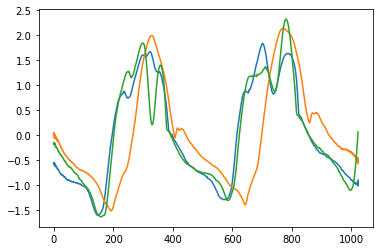

In [6]:
x = features['7_z'].to_numpy().reshape(-1, N_SAMPLES)
for i in range(20, 23):
    plt.plot(x[i, :])

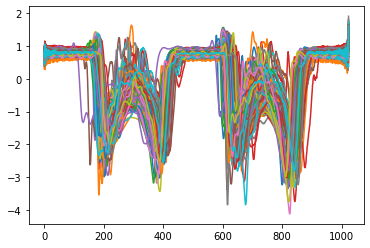

In [7]:
y = target['fx'].to_numpy().reshape(-1, N_SAMPLES)
for i in range(100):
    plt.plot(y[i, :])

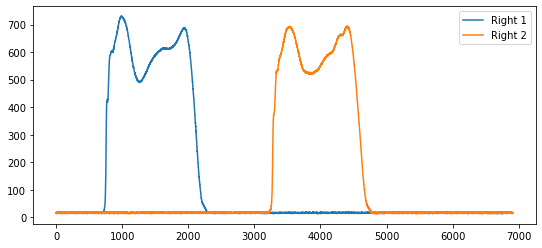

In [12]:
path = '../../Dataset/gait-dbase-2/Participant14/Raw_Data/V35/T4.c3d'
content = c3d(path, extract_forceplat_data=True)
force_z_1 = content['data']['platform'][0]['force'][2, :]
force_z_2 = content['data']['platform'][1]['force'][2, :]
force_z_3 = content['data']['platform'][2]['force'][2, :]
force_z_4 = content['data']['platform'][3]['force'][2, :]
force_z_5 = content['data']['platform'][4]['force'][2, :]
force_z_6 = content['data']['platform'][5]['force'][2, :]
# trajectory_z_l = content['data']['points'][2, 9:15, :]
# trajectory_z_r = content['data']['points'][2, 20:26, :]
trajectory_z_r = content['data']['points'][2, 6:11, :]
trajectory_z_l = content['data']['points'][2, 18:23, :]

# clean_grf = GrfFilter.apply(force_z_2)
plt.figure(figsize=(9, 4))
# plt.plot(force_z_1, label='Force plate 1')
plt.plot(force_z_2, label='Right 1')
# plt.plot(force_z_3, label='Left 1')
plt.plot(force_z_4, label='Right 2')
# plt.plot(force_z_5, label='Left 2')
# plt.plot(force_z_6, label='Force plate 6')
# plt.plot(trajectory_z_l.T)

plt.legend()

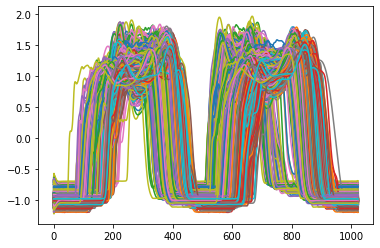

In [8]:
y = target['fz'].to_numpy().reshape(-1, N_SAMPLES)
for i in range(y.shape[0]):
    plt.plot(y[i, :])

In [9]:
i

1959